1>
https://www.toptal.com/big-data/consistent-hashing#:~:text=Consistent%20Hashing%20is%20a%20distributed,without%20affecting%20the%20overall%20system.

2>
https://www.ably.io/blog/implementing-efficient-consistent-hashing/    

# Hashing revisited

Remember the good old naïve Hashing approach that you learnt in college? Using a hash function, we ensured that resources required by computer programs could be stored in memory in an efficient manner, ensuring that in-memory data structures are loaded evenly. We also ensured that this resource storing strategy also made information retrieval more efficient and thus made programs run faster.

The classic hashing approach used a hash function to generate a pseudo-random number, which is then divided by the size of the memory space to transform the random identifier into a position within the available space. Something that looked like the following:
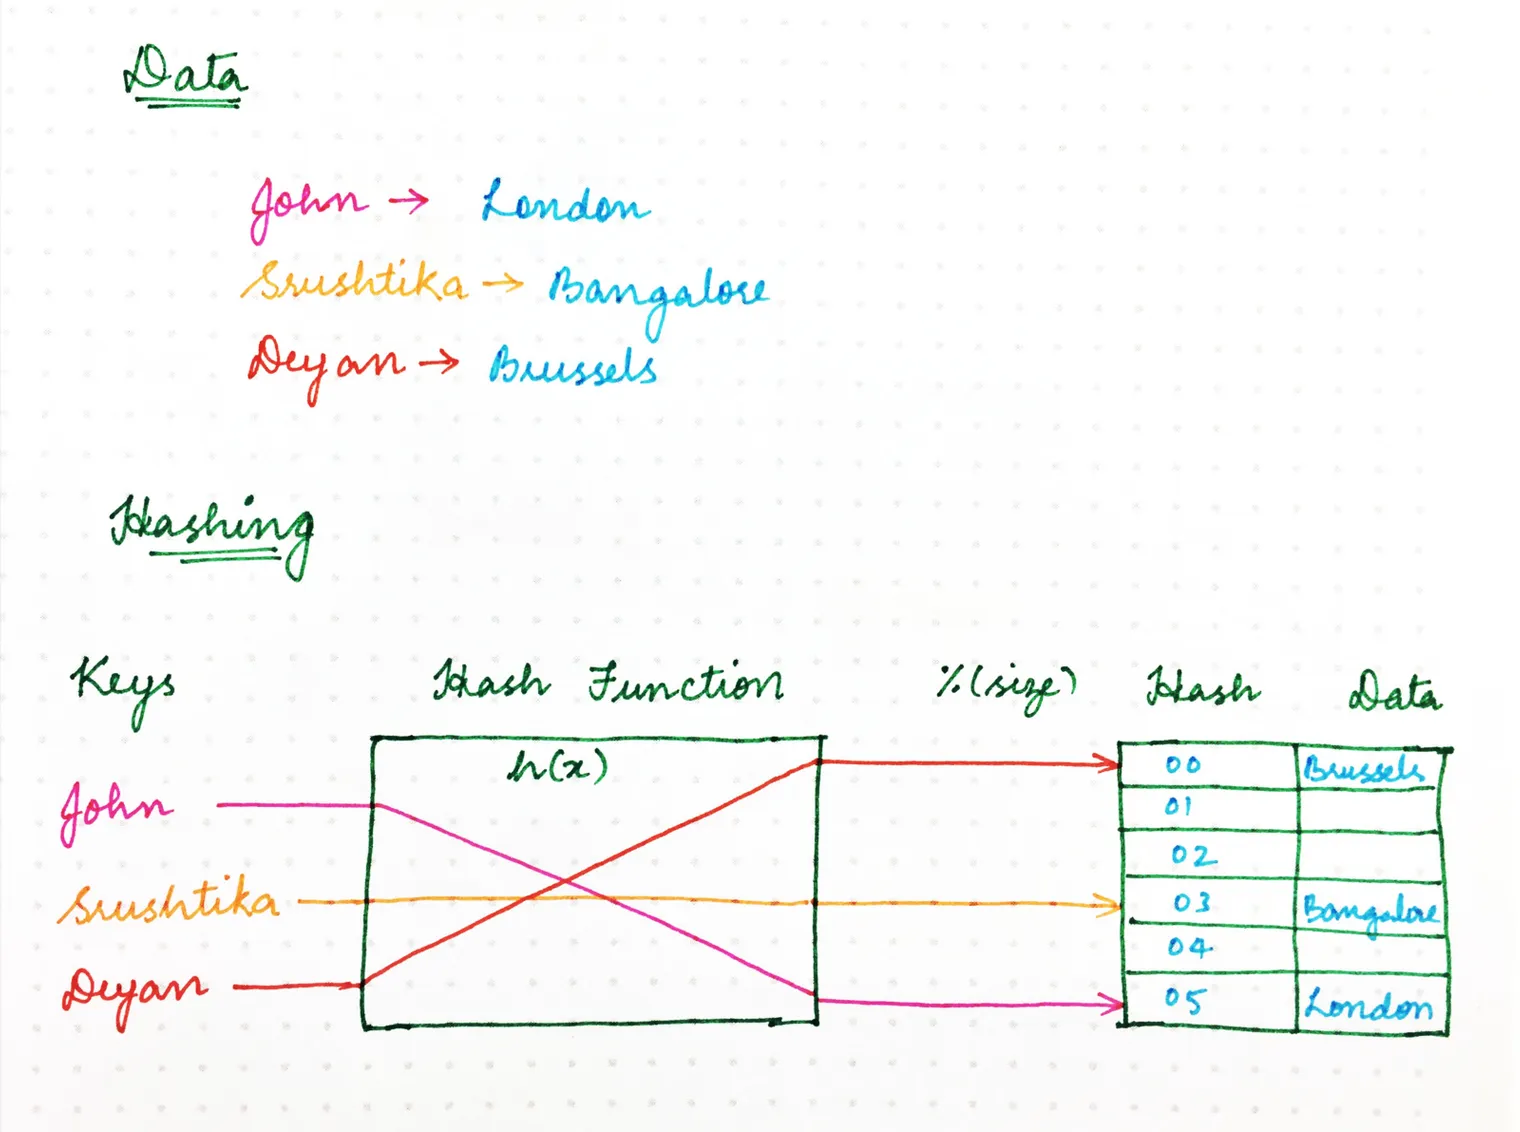    
    
## Why can’t we use the same method for handling requests over the network?

In a scenario where various programs, computers, or users are requesting some resources from multiple server nodes, we need a mechanism to map requests evenly to available server nodes, thus ensuring that load is balanced, and consistent performance can be maintained. We could consider the server nodes to be the placeholders to which one or more of the requests could be mapped to.

Now let’s take a step back. In the classic hashing method, we always assume that:

* The number of memory locations is known, and
* This number never changes.

For example, at Ably, we routinely scale the cluster size up and down throughout the day, and also have to cope with unexpected failures. But, if we consider the scenario mentioned above, we cannot guarantee that the number of server nodes will remain the same. What if one of them unexpectedly fails?With a naive hashing approach we would end up needing to rehash every single key as the new mapping is dependant on the number of nodes/ memory locations as shown below:


   


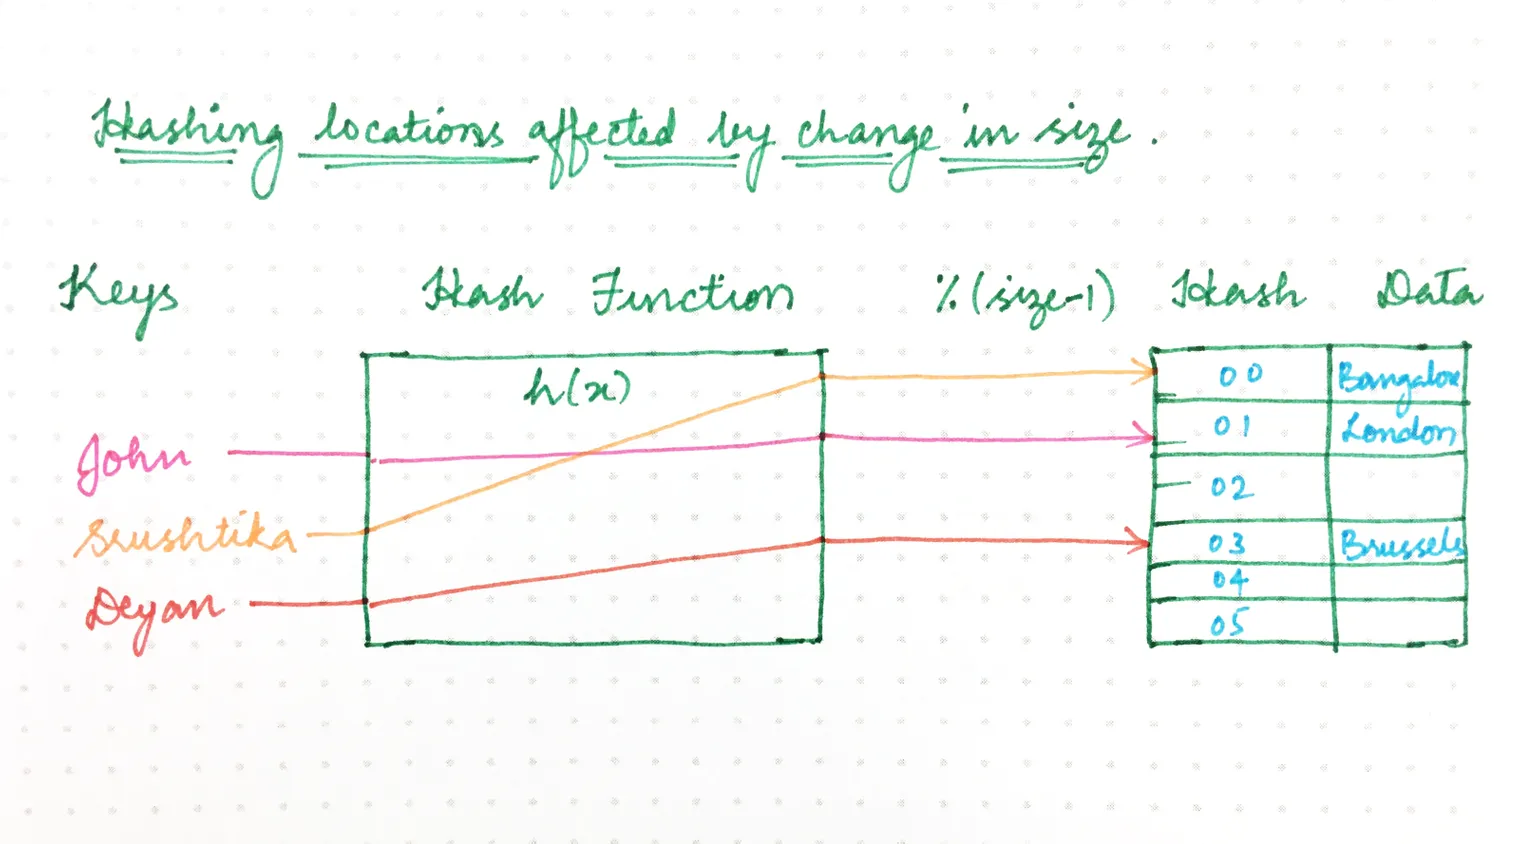
                BEFORE

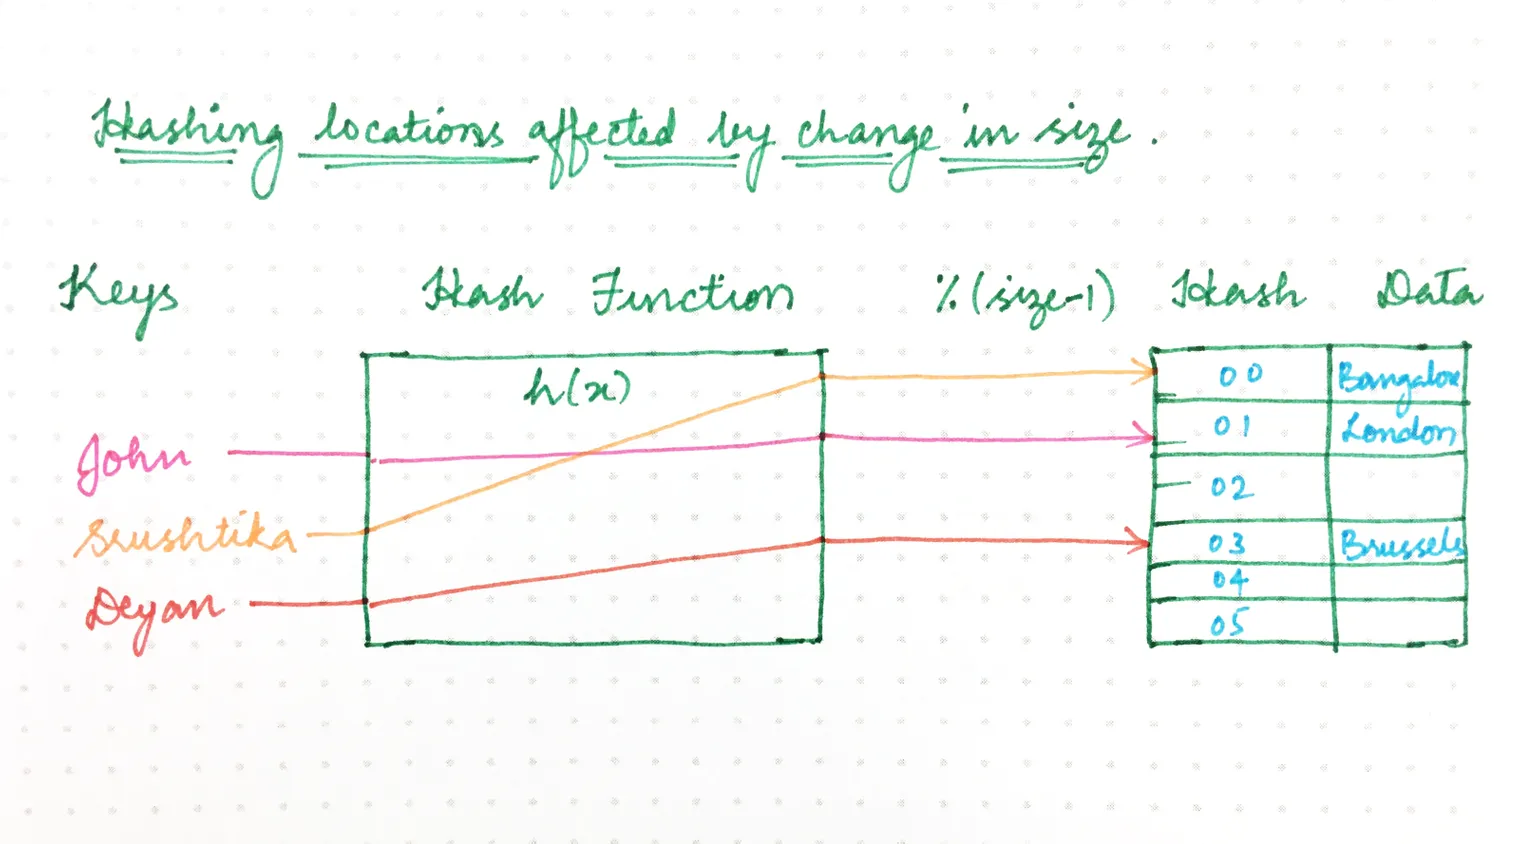
                AFTER

The problem in a distributed system with simple rehashing — where the placement of every key moves — is that there is state stored on each node; a small change in the cluster size for example, could result in a huge amount of work to reshuffle all the data around the cluster. As the cluster size grows, this becomes unsustainable as the amount of work required for each hash change grows linearly with cluster size. This is where the concept of consistent hashing comes in.

## Consistent Hashing: what is it anyway?

Consistent Hashing can be described as follows:

* It represents the resource requestors (which we shall refer to as ‘requests’ from now on, for the purpose of this blog post) and the server nodes in some kind of a virtual ring structure, known as a hashring.

* The number of locations is no longer fixed, but the ring is considered to have an infinite number of points and the server nodes can be placed at random locations on this ring. Of course, choosing this random number again can be done using a hash function but the second step of dividing it with the number of available locations is skipped as it is no longer a finite number.

* The requests, ie the users, computers or serverless programs, which are analogous to keys in classic hashing approach, are also placed on the same ring using the same hash function.

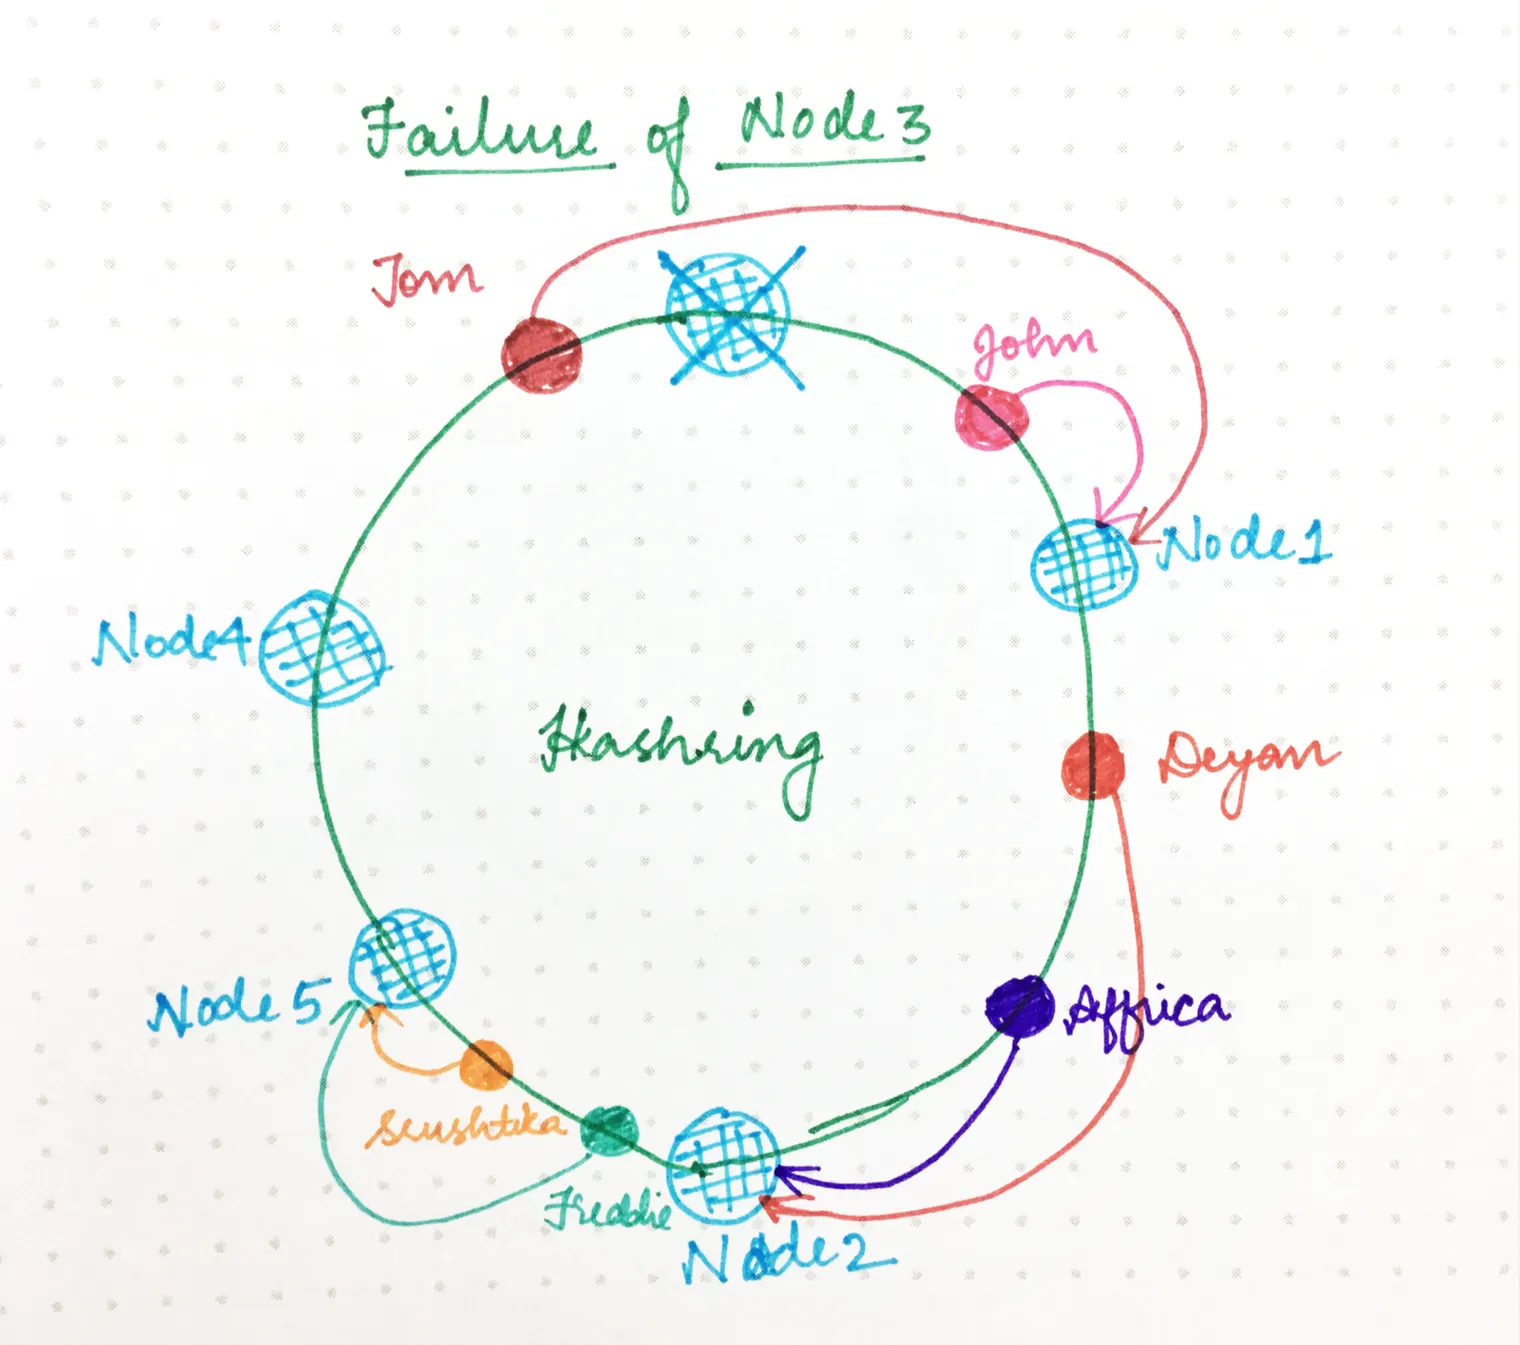


So, how is the decision about which request will be served by which server node made? If we assume the ring is ordered so that clockwise traversal of the ring corresponds to increasing order of location addresses, each request can be served by the server node that first appears in this clockwise traversal; that is, the first server node with an address greater than that of the request gets to serve it. If the address of the request is higher than the highest addressed node, it is served by the server node with the least address, as the traversal through the ring goes in a circular fashion. This is illustrated below:

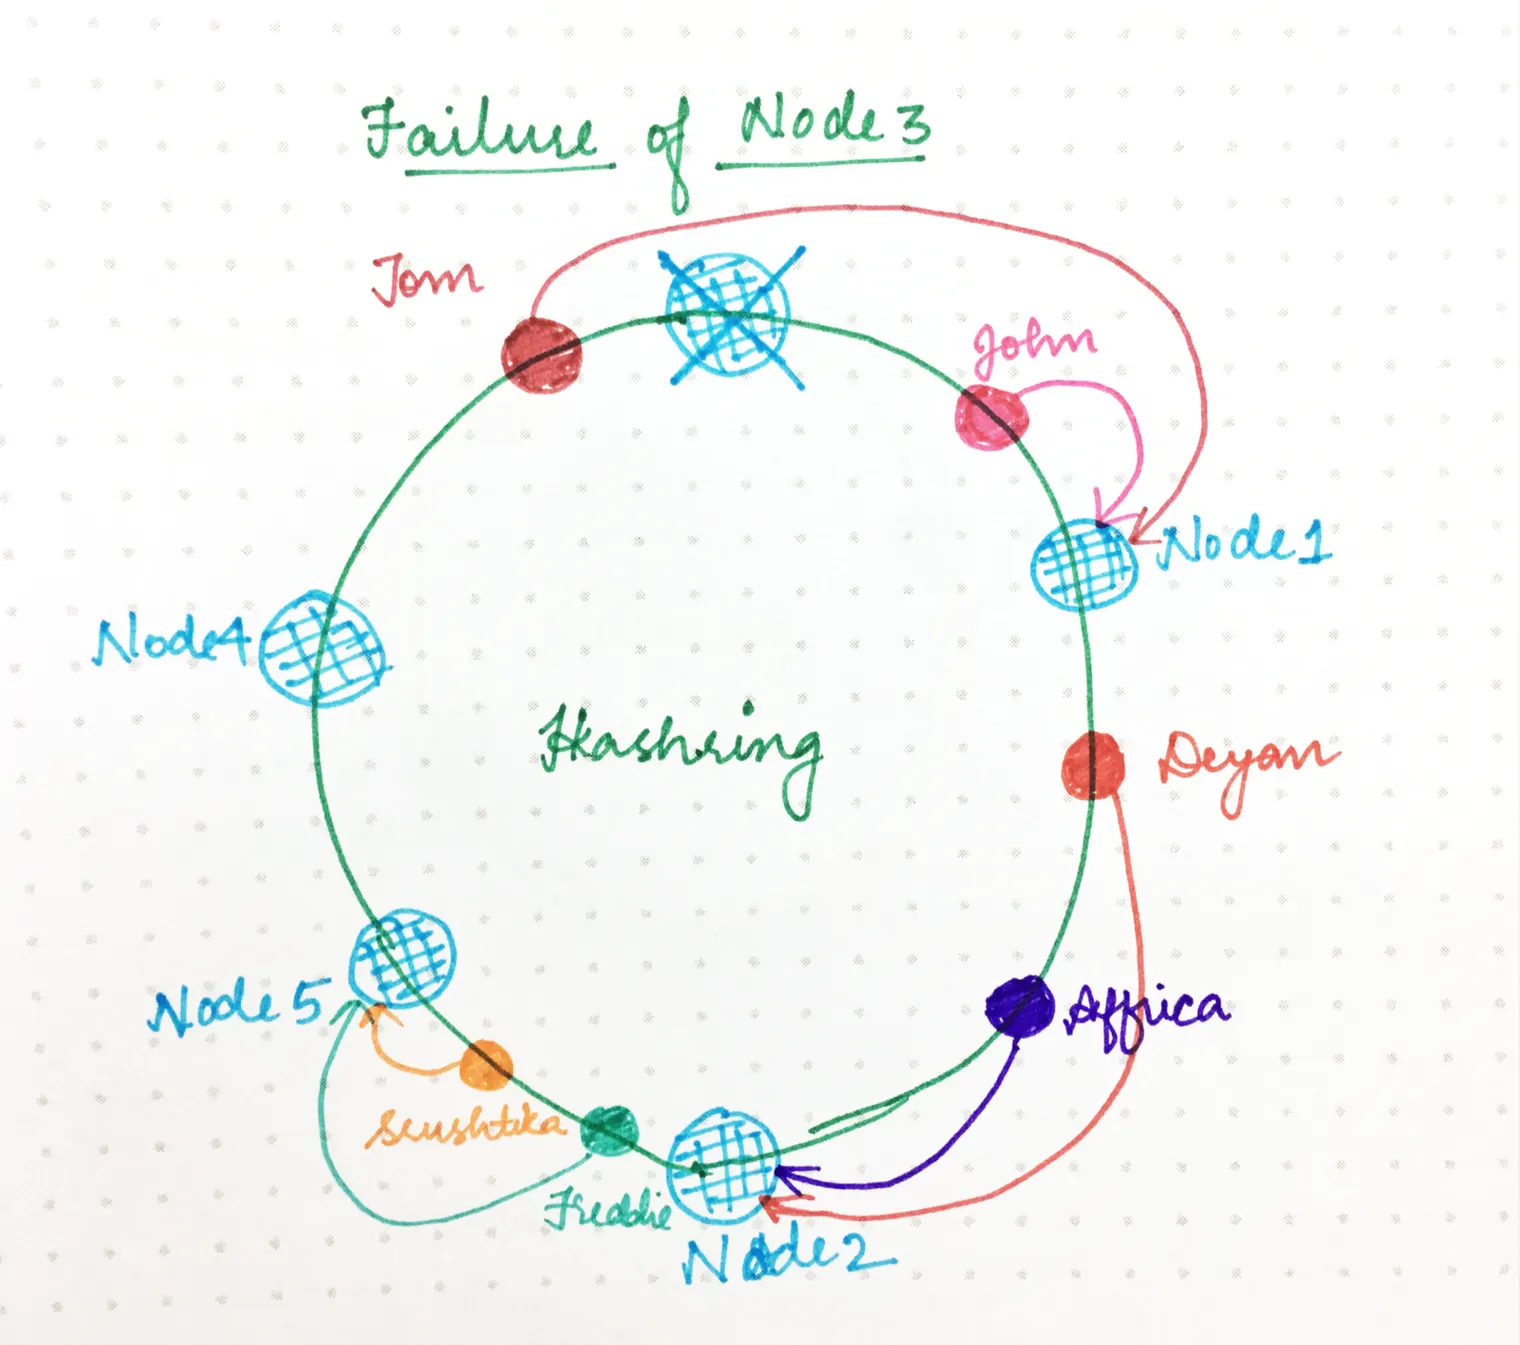


Theoretically, each server node ‘owns’ a range of the hashring, and any requests coming in at this range will be served by the same server node. Now, what if one of these server nodes fails, say Node 3, the range of the next server node widens and any request coming in all of this range, goes to the new server node. But that’s it. It’s just this one range, corresponding to the failed server node, that needed to be re-assigned, while the rest of the hashring and request-node assignments still remain unaffected. This is in contrast to the classic hashing technique in which the change in size of the hash table effectively disturbs ALL of the mappings. Thanks to **consistent hashing, only a portion (relative to the ring distribution factor) of the requests will be affected by a given ring change. (A ring change occurs due to an addition or removal of a node causing some of the request-node mappings to change.)

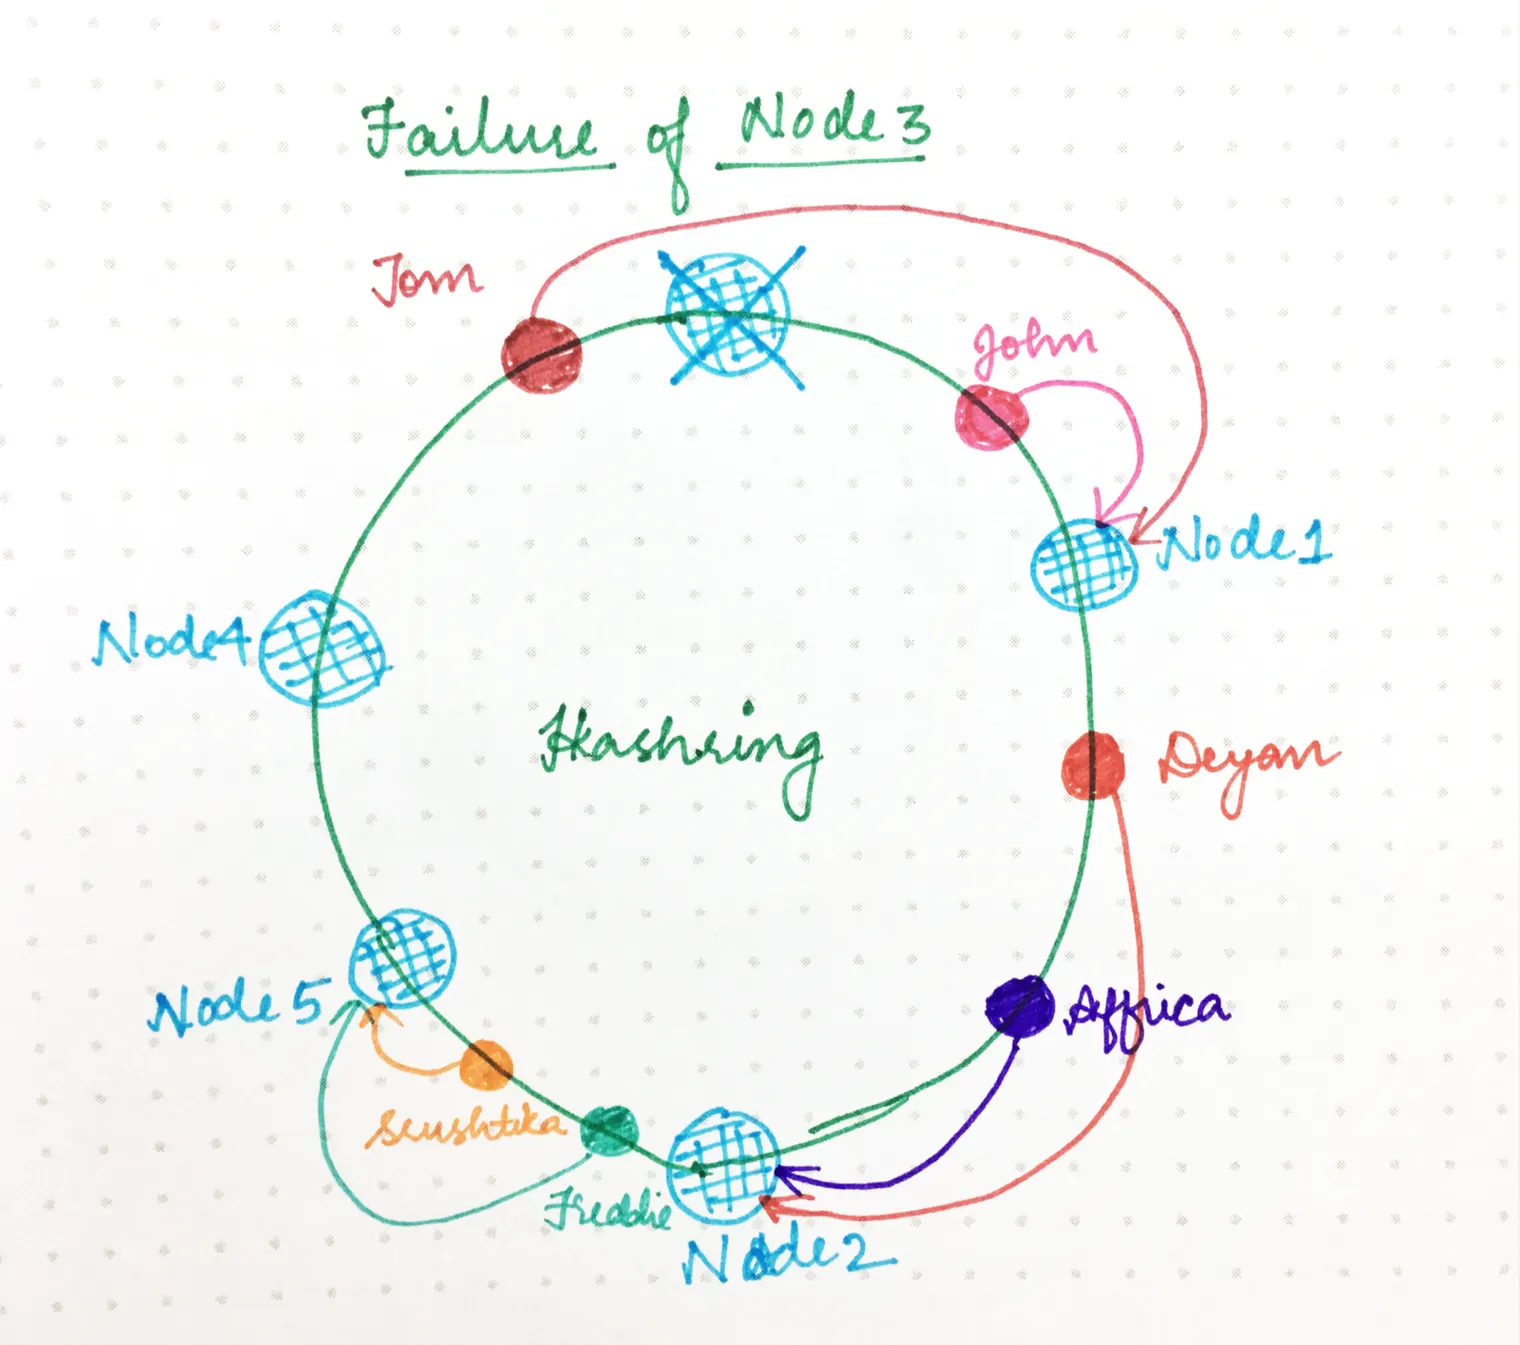

## An efficient implementation approach
Now that we’re comfortable with what a hash ring is…

We need to implement the following to make it work:

* A mapping from our hash space to nodes in the cluster allowing us to find the nodes responsible for a given request.

* A collection those requests to the cluster that resolve to a given node. Moving forward, this will allow us to find out which hashes are affected by the addition or removal of a particular node.


## Mapping
In order to accomplish the first part above, we need the following:

* A hash function for computing the position in the ring given an identifier for requests.

* A way to find out which node corresponds to a hashed request.

To find out the node corresponding to a particular request, we can use a simple data structure for it’s representation, comprising of the following:

* An array of hashes that correspond to nodes in the ring.

* A map (hash table) for finding the node corresponding to a particular request.

This is essentially a primitive representation of an ordered map.

To find a node responsible for a given hash in the above structure, we need to:

* Perform a modified binary search to find the first node-hash in the array that is equal to or greater than (≥) the hash you wish to look up.

* Look up the node corresponding to the found node-hash in the map

## Addition or removal of a node

As we saw in the beginning of the article, when a new node is added, some portion of the hashring, comprising of various requests, must be assigned to that node. Conversely, when a node is removed, the requests that had been assigned to that node will need to be handled by some other node.

## How do we find those the requests that are affected by a ring change?

One solution is to iterate through all the requests allocated to a node. For each request, we decide whether it falls within the bounds of the ring change that has occurred, and move it elsewhere if necessary.

However, the work required to do this increases as the number of requests allocated to a given node scales. The situation becomes worse as the number of ring changes that occur tends to increase as the number of nodes increases. In the worst case, since ring changes are often related to localised failures, an instantaneous load associated with a ring change could increase the likelihood of other affected nodes as well, possibly leading to cascading issues across the system.

To counter this, we would like relocation of requests to be as efficient as possible. Ideally, we’d store all requests in a data structure that allows us to find those affected by a single hash change anywhere on the ring

## Efficiently finding affected hashes

Adding or removing a node from the cluster will change the allocation of requests in some portion of the ring, which we will refer to as the affected range. If we know the bounds of the affected range, we will be able to move the requests to their correct location.

To find the the bounds of the affected range, starting at the hash H of the added or removed node, we can move backwards (counter-clockwise in the diagram) around the ring from H until another node is found. Let’s call the hash of this node S (for start). The requests that are anti-clockwise of this node will be located to it, so they won’t be affected.

* Note that this is a simplified depiction of what happens; in practice, the structure, and algorithm, are further complicated because we use replication factors of greater than, 1 and specialised replication strategies in which only a subset of nodes is applicable to any given request.

The requests that have placement hashes in the range between the found node and the node that was added(or removed) are those that need to be moved.

## Efficiently finding the requests in the affected range

One solution is simply to iterate through all the requests corresponding to a node, and update the ones that have a hash within the range.

In JavaScript that might look something like this:for (const request of requests) {  if (contains(S, H, request.hash)) {    /* the request is affected by the change */    request.relocate();  }}function contains(lowerBound, upperBound, hash) {   const wrapsOver = upperBound < lowerBound;   const aboveLower = hash >= lowerBound;   const belowUpper = upperBound >= hash;   if (wrapsOver) {     return aboveLower || belowUpper;   } else {     return aboveLower && belowUpper;   }}

Since the ring is circular, it is not enough to just find requests where S <= r < H, since S may be greater than H (meaning that the range wraps over the top of the ring). The function contains() handles that case.

Iterating through all the requests on a given node is fine as long as the number of requests is relatively low or if the addition or removal of nodes is relatively rare.

However, the work required increases as the number of requests at a given node grows, and worse, ring changes tend to occur more frequently as the number of nodes increases, whether due to automated scaling or failover, triggering simultaneous load across the system to rebalance the requests.

In the worst case, load associated with this may increase the likelihood of failures on other nodes, possibly leading to cascading issues across the system.

To mitigate this, we can also store requests in a separate ring data-structure similar to the one discussed earlier. In this ring, a hash maps directly to the request that is located at that hash.

Then we can locate the requests within a range by doing the following:

* Locate the first request following the start of the range, S.

* Iterate clockwise until you find a request that has a hash outside the range.

* Relocate those requests that were inside the range.

The number of requests that need to be iterated for a given hash update will on average be R/N where R is the number of requests located in the range of the node and N is the number of hashes in the ring, assuming an even distribution of requests.
_____________________________________________________________________________________________________________________

Let’s put the above explanation into action with a working example:

Suppose that we have a cluster containing two nodes A and B.

Let’s randomly generate a ‘placement hash’ for each of these nodes: (assuming 32-bit hashes), so we get

A:0x5e6058e5

B:0xa2d65c0

This places the nodes on an imaginary ring where the numbers 0x0, 0x1, 0x2… are placed consecutively up to 0xffffffff, which is in turn curled to be followed by 0x0.

Since node A has the hash 0x5e6058e5, it is responsible for any request that hashes into the range0xa2d65c0+1 up to 0xffffffff and from 0x0 up to 0x5e6058e5, as shown below:

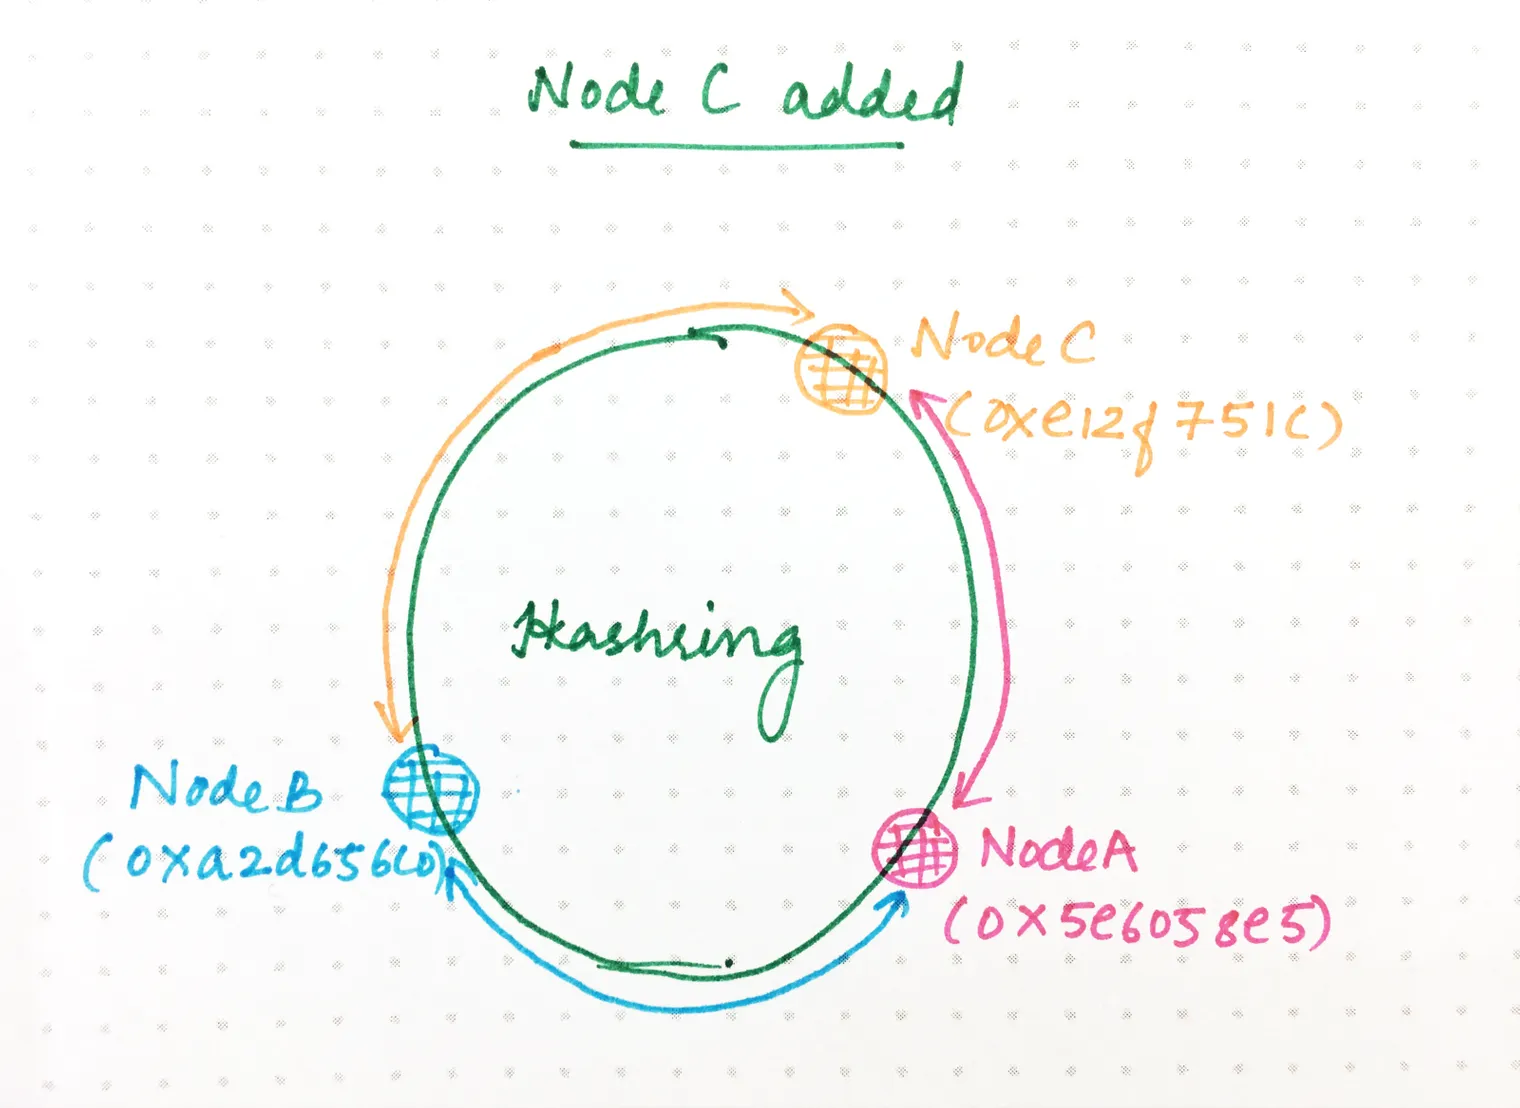

B on the other hand is responsible for the range0x5e6058e5+1up to 0xa2d65c0. Thus, the entire hash space is distributed.

This mapping from nodes to their hashes needs to be shared with the whole cluster so that the result of ring calculation is always the same. Thus, any node that requires a particular request can determine where it lives

Say we want to find (or create) a request that has the identifier ‘bobs.blog@example.com’.

* We compute a hash H of the identifier, say 0x89e04a0a

* We look at the ring and find the first node with a hash that is greater than H. Here that happens to be B.

Therefore B is the node responsible for that request. If we need the request again, we will repeat the above steps and land again on the same node, which has the state we need.

This example is a bit oversimplified. In reality, having a single hash for each node is likely to distribute the load quite unfairly. As you may have noticed, in this example, B is responsible for (0xa2d656c0-0x5e6058e5)/232 = 26.7% of the ring, while A is responsible for the rest. Ideally, each node would be responsible for an equal portion of the ring.

One way to make this fairer is to generate multiple random hashes for each node, as below:

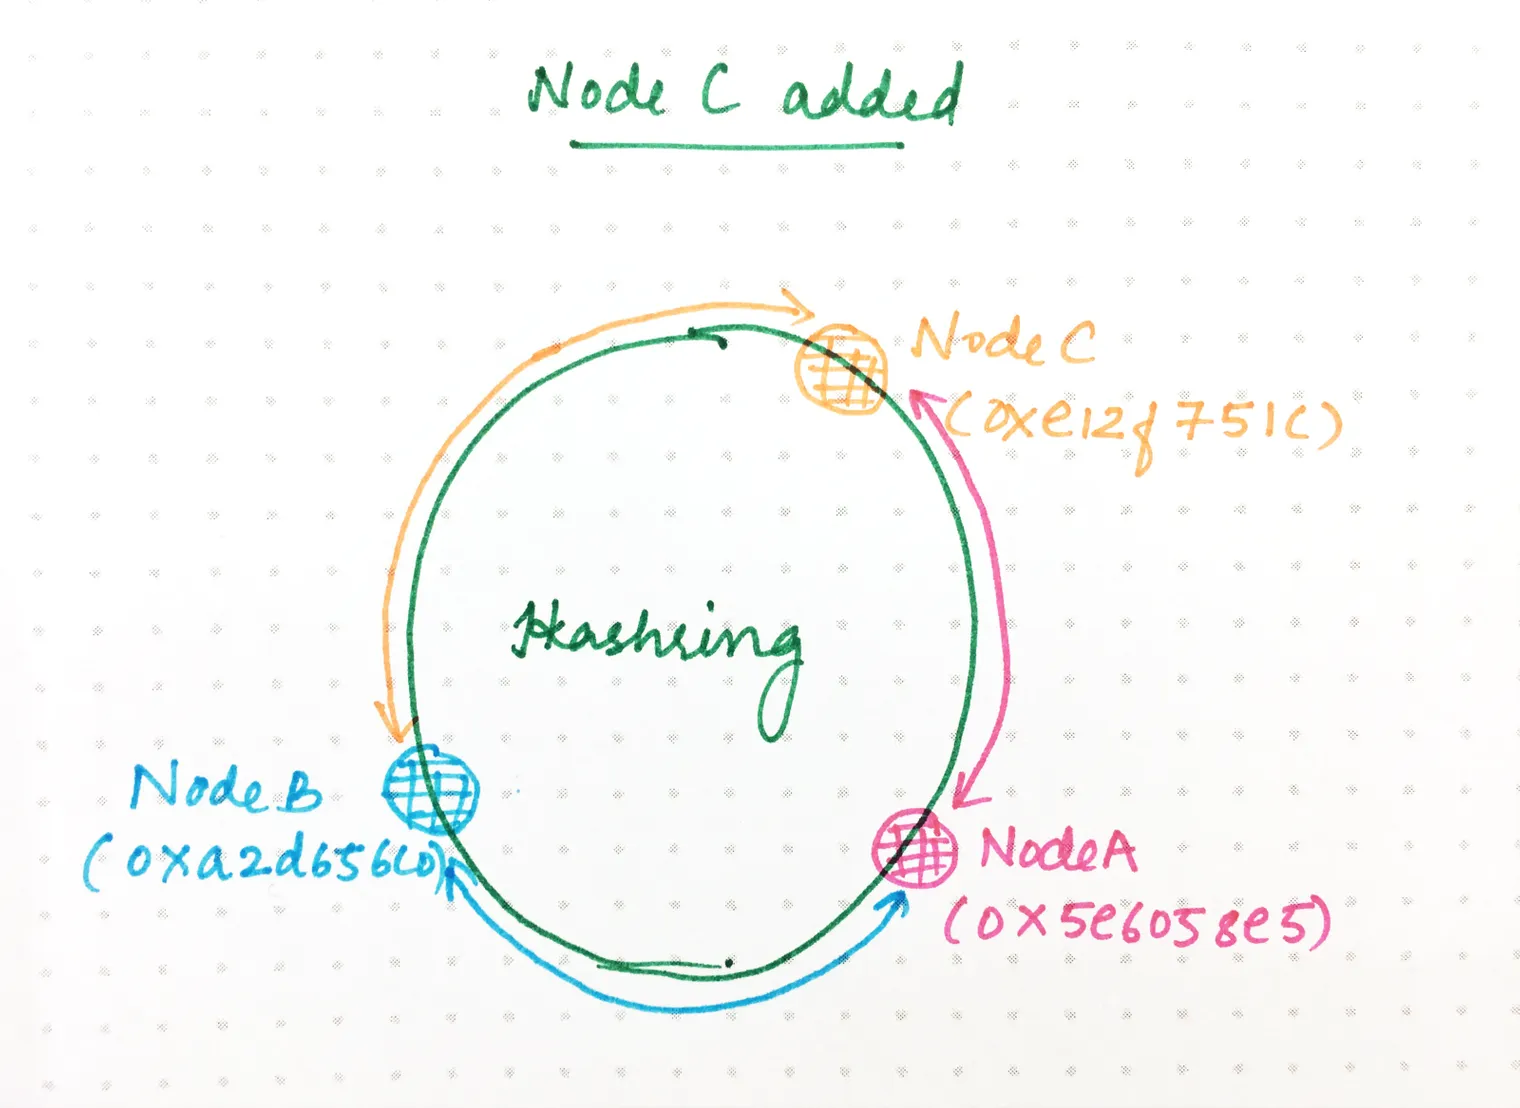

In reality, we find the results of this are still unsatisfactory, so we divide the ring into 64 equally sized segments and ensure a hash for each node is placed somewhere in each segment; the details of this are not important however. The aim is just to ensure each node is responsible for an equal portion of the ring, so that load is evenly distributed. (Another advantage of having multiple hashes for each node is that the hashes can be added to or removed from the ring gradually, to avoid sudden spikes of load. )

Suppose that now we add a new node to the ring called C. We generate a random hash for C.

A:0x5e6058e5

B:0xa2d65c0

C:0xe12f751c

Now, the ring space between 0xa2d65c0 + 1 and 0xe12f751c (which used to hash to A) are now delegated to C. All the other requests will continue to hash to the same node as before. To handle this shift of power, all the requests in that range that already exist on A will need to move all their state over to C.

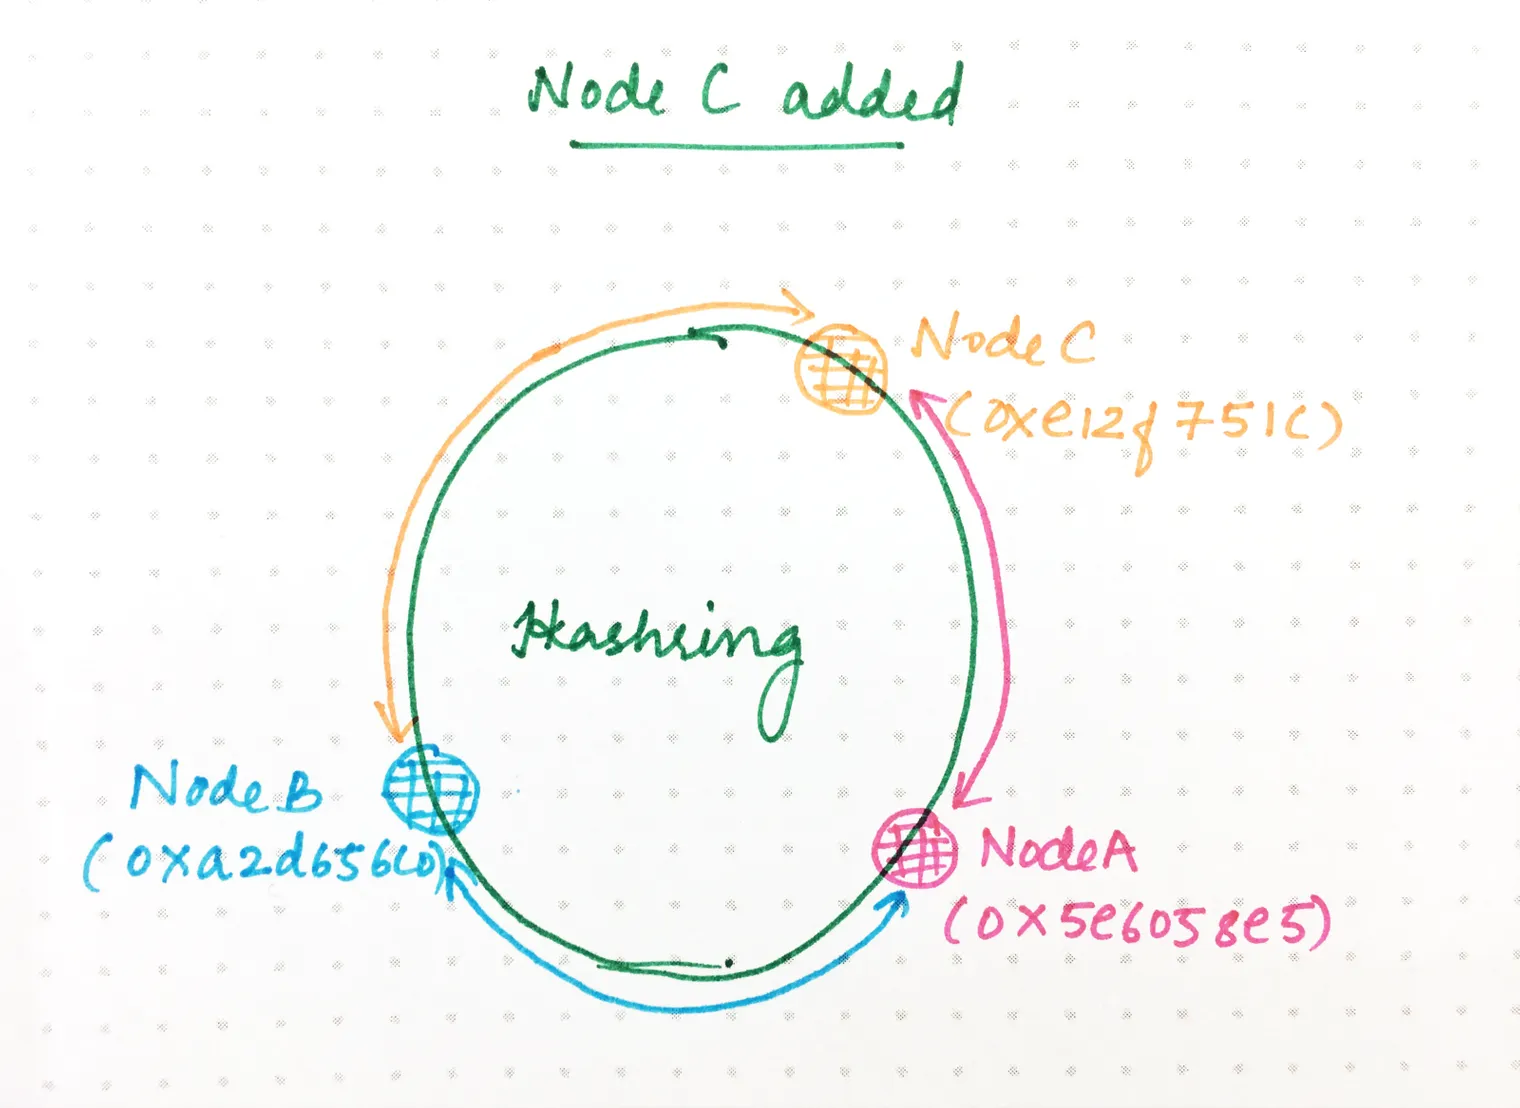

You now understand why hashing is needed in distributed systems to distribute load evenly. Consistent hashing however is required to ensure minimisation of the amount of work needed in the cluster whenever there is a ring change.

Additionally, nodes need to exist on multiple locations on the ring to ensure statistically the load is more likely to be distributed more evenly. Iterating an entire hash ring for each ring change is inefficient. As your distributed system scales, having a more efficient way to determine what’s changed is necessary to minimise the performance impact of ring changes as much as possible. New index and data types are needed to solve this.